# A simple Maxent model

Here's an end-to-end example for fitting and applying a Maxent model.

This is to demonstrate the simplest pattern of model training. Full model training and evaluation should include creating train/test splits, cross-validation, feature selection, which aren't covered here.

The `elapid` sample data are occurrence records for *Ariolimax buttoni*, a species of banana slug native to coastal California, annotated with climate and vegetation data.

In [1]:
# packages
import elapid as ela

import rasterio as rio
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import metrics
import warnings

# paths
https = "https://earth-chris.github.io/images/research"
vector = f"{https}/ariolimax-buttoni.gpkg"
raster_names = [
    "ca-cloudcover-mean.tif",
    "ca-cloudcover-stdv.tif",
    "ca-leafareaindex-mean.tif",
    "ca-leafareaindex-stdv.tif",
    "ca-surfacetemp-mean.tif",
    "ca-surfacetemp-stdv.tif",
]
rasters = [f"{https}/{raster}" for raster in raster_names]
labels = [raster[3:-4] for raster in raster_names]

# preferences
%matplotlib inline
mpl.style.use('ggplot')
warnings.filterwarnings("ignore")

print(f"Notebook last run with elapid version {ela.__version__}")

Notebook last run with elapid version 1.0.1


In [2]:
# read the presence data, draw background point samples
presence = gpd.read_file(vector)
background = ela.sample_raster(rasters[0], count=10_000)

# merge datasets and read the covariates at each point location
merged = ela.stack_geodataframes(presence, background, add_class_label=True)
annotated = ela.annotate(merged, rasters, drop_na=True, quiet=True)

# split the x/y data
x = annotated.drop(columns=['class', 'geometry'])
y = annotated['class']

# train the model
model = ela.MaxentModel(transform='cloglog', beta_multiplier=2.0)
model.fit(x, y)

# evaluate training performance
ypred = model.predict(x)
auc = metrics.roc_auc_score(y, ypred)
print(f"Training AUC score: {auc:0.3f}")

# save the fitted model to disk
ela.save_object(model, 'demo-maxent-model.ela')

Training AUC score: 0.981


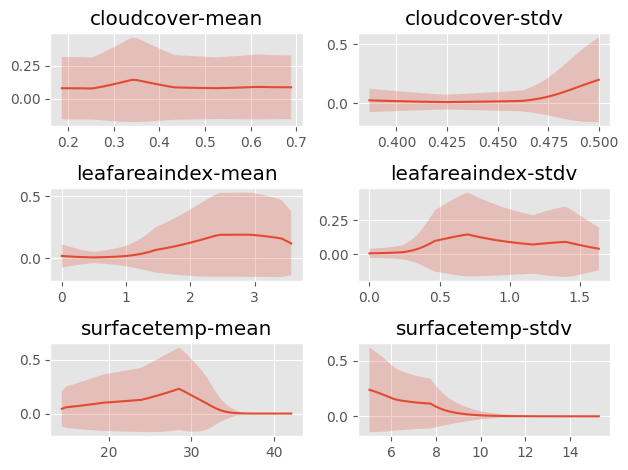

In [3]:
# partial dependence plots show how model predictions vary across the range of covariates
fig, ax = model.partial_dependence_plot(x, labels=labels, dpi=100)

In [4]:
# write the model predictions to disk
output_raster = 'demo-maxent-predictions.tif'
ela.apply_model_to_rasters(model, rasters, output_raster, quiet=True)

# and read into memory
with rio.open(output_raster, 'r') as src:
    pred = src.read(1, masked=True)

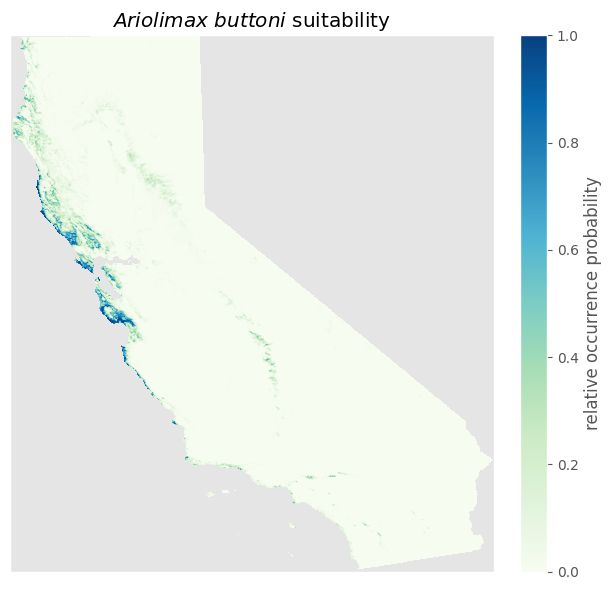

In [5]:
# plot the suitability predictions
fig, ax = plt.subplots(1, 1, figsize=(7, 6), dpi=100)
plot = ax.imshow(pred, vmin=0, vmax=1, cmap='GnBu')
ax.set_title('$Ariolimax\ buttoni$ suitability')
ax.set_xticks([])
ax.set_yticks([])
cbar = plt.colorbar(plot, ax=ax, label="relative occurrence probability", pad=0.04)
plt.tight_layout()